In [1]:
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

from ho_stray_field import *
from ho_stray_field.bspline import BSpline
from ho_stray_field.tensor_grid import TensorGrid
from ho_stray_field.magnetostatic import DomainState, solve_energy, fit_mag
from ho_stray_field.sources import m_uniform, flower_state, vortex_state
from ho_stray_field.utils import write_csv_row

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")

# Higher order stray field magnetostatic energy computation

In this notebook, the higher order stray field method is used for magnetostatic energy
computation. 

First we define the `setup` and the `solve` function. `setup` initializes a solver for the respective domain and computes factor matrices to solve the superpotential. The `solve` function computes the
magnetostatic energy.

In [2]:
target_tg = TensorGrid(*[jnp.linspace(-0.5, 0.5, 2)] * 3).to_gauss(200)

@partial(jax.jit, static_argnames=("s", "potential"))
def setup(model, target_tg, mag_model=None, mag_quad_grid=None, s=100, potential="superpotential"):
    state = DomainState.init(
        pot_elm=model,
        mag_elm=mag_model,
        pot_quad_grid=target_tg,
        mag_quad_grid=mag_quad_grid,
        target_quad_grid=target_tg,
        gs_terms=s,
        gk_epsabs=1e-13,
        gk_epsrel=0.0,
        gk_order=41,
        gk_max_ninter=50,
        potential=potential
    )
    return state

@jax.jit
def solve(state: DomainState, mag) -> jax.Array:
    return solve_energy(state, mag)


## Energy for a uniformly magnetized cube

We solve the energy for a uniform magnetization within the unit cube. We use the same TPELM for superpotential and magnetization ($r_p=r_p'$).

The energy is computed for different ranks $r$ and different B-spline orders $k$. The number of exponential sum terms $S=100$ is used. All fitting procedures use 200 Gauss-Legendre quadrature points for each dimension.

In [ ]:
# uniform state
e_true = 1 / 6
ks = [4, 5, 6, 7, 8, 9]
ns = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]

for k in ks:
    for n in ns:
        mag_grid = TensorGrid(*[jnp.linspace(-0.5, 0.5, 2)] * 3)
        mag_model = BSpline(mag_grid, degree=0)
        grid = TensorGrid(*[jnp.linspace(-0.5, 0.5, n)] * 3)
        model = BSpline(grid, degree=k - 1)
        #solver = setup(model, target_tg, mag_model=mag_model, mag_quad_grid=mag_grid.to_gauss(1), s=100)  # fast version with r=1, k=0
        solver = setup(model, target_tg, s=100)
        mag = fit_mag(solver, m_uniform)  # prefit magnetization to functional Tucker format
        e = solve(solver, mag).block_until_ready()
        err = jnp.abs(e - e_true)
        t = %timeit -q -o -n 5 -r 1 solve(solver, mag).block_until_ready()
        print(f"k={k}, n={n}, energy={e:.6e}, error={err:.4e}, fitting_time={t.average * 1000:.3f} ms")
        data = {
            "k": k,
            "r": n,
            "s": 100,
            "energy": e,
            "error": jnp.abs(e - 1 / 6),
            "run_time": t.average
        }
        write_csv_row("energy_uniform.csv", data)

k=4, n=10, energy=1.663435e-01, error=3.2318e-04, fitting_time=1.734 ms


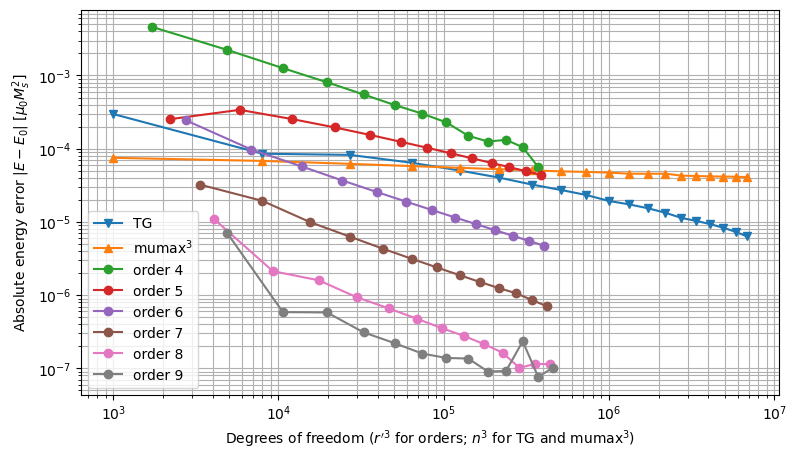

In [ ]:
tg_result = pd.read_csv("TG_uniform_cube_table.txt", sep=" ")
mumag3_result = pd.read_csv("mumax_uniform_state.csv")
mumag3_result["DoF"] = mumag3_result.Nx * mumag3_result.Ny * mumag3_result.Nz
mumag3_result["error"] = abs(mumag3_result.energy - 1 / 6)
hosf_result = pd.read_csv("energy_uniform.csv")
ks = hosf_result.k.unique()

e_true = 1 / 6
plt.figure(figsize=(9, 5))

plt.plot(tg_result.DoF[:-1], abs(tg_result.energy[:-1] - 1 / 6), "-v", label="TG")
plt.plot(mumag3_result.DoF[:-1], mumag3_result.error[:-1], "-^", label=r"mumax$^3$")
for k in ks:
    res = hosf_result[hosf_result.k == k]
    plt.plot([(_n + k - 2)**3 for _n in res.n], abs(res.energy - 1 / 6), "-o", label = f"order {k}")
    
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"Degrees of freedom ($r'^3$ for orders; $n^3$ for TG and mumax$^3$)")
plt.ylabel(r"Absolute energy error $|E - E_0|$ $[\mu_0 M_s^2]$")
plt.grid(which="both")
plt.legend()
plt.show()

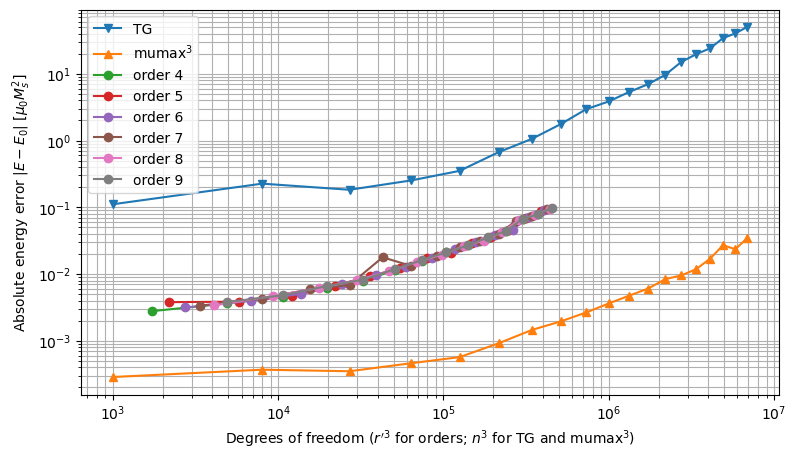

In [ ]:

e_true = 1 / 6
plt.figure(figsize=(9, 5))

plt.plot(tg_result.DoF[:-1], tg_result["cpu-times(s)"][:-1], "-v", label="TG")
plt.plot(mumag3_result.DoF[:-1], mumag3_result.eval_time[:-1], "-^", label=r"mumax$^3$")
for k in ks:
    res = hosf_result[hosf_result.k == k]
    plt.plot([(_n + k - 2)**3 for _n in res.n], res.run_time, "-o", label = f"order {k}")
    
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"Degrees of freedom ($r'^3$ for orders; $n^3$ for TG and mumax$^3$)")
plt.ylabel(r"Run time $[s]$")
plt.grid(which="both")
plt.legend()
plt.show()

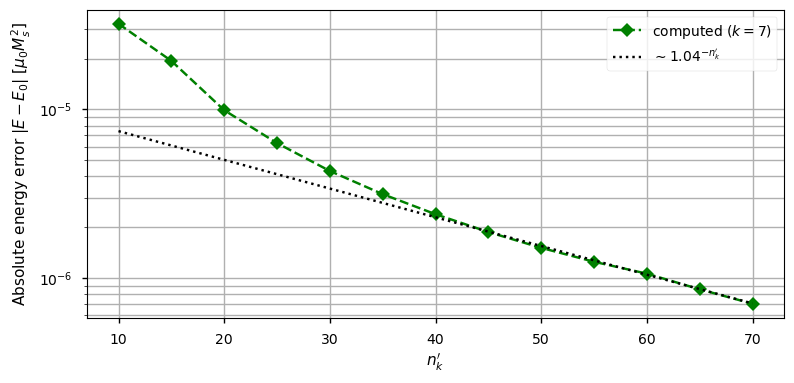

In [ ]:
hosf_result = pd.read_csv("energy_uniform.csv")
k = 7
res = hosf_result[hosf_result.k == k]
with style.context("seaborn-v0_8-notebook"):
    plt.figure(figsize=(9, 4))
    plt.plot(res.n, abs(res.energy - 1 / 6), "--D", color="green", label=f"computed ($k={k}$)")
    plt.plot(res.n, [1.1e-5 * 1.04 ** (-_r) for _r in res.n], ":", color="k", label=r"$\sim 1.04^{-n_k'}$")
    plt.xlabel("$n_k'$")
    plt.ylabel(r"Absolute energy error $|E - E_0|$ $[\mu_0 M_s^2]$")
    plt.yscale("log")
    plt.grid(axis="x")
    plt.grid(axis="y", which="both")
    plt.legend()
    
plt.show()

In [ ]:
target_tg = TensorGrid(*[jnp.linspace(-0.5, 0.5, 2)] * 3).to_gauss(200)
k = 9
n = 70

ss = [40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

for s in ss:
    mag_grid = TensorGrid(*[jnp.linspace(-0.5, 0.5, 2)] * 3)
    mag_model = BSpline(mag_grid, degree=0)
    grid = TensorGrid(*[jnp.linspace(-0.5, 0.5, n)] * 3)
    model = BSpline(grid, degree=k - 1)
    solver = setup(model, target_tg, s=s, potential="superpotential")
    mag = fit_mag(solver, m_uniform)  # prefit magnetization to functional Tucker format
    e = solve(solver, mag)
    t = %timeit -q -o -n 5 -r 1 solve(solver, mag).block_until_ready()
    data = {
        "k": k,
        "n": n,
        "s": s,
        "energy": e,
        "error": jnp.abs(e - 1 / 6),
        "run_time": t.average
    }
    write_csv_row("energy_uniform_s_sp.csv", data)

In [ ]:
target_tg = TensorGrid(*[jnp.linspace(-0.5, 0.5, 2)] * 3).to_gauss(200)
k = 9
n = 70

ss = [40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

for s in ss:
    mag_grid = TensorGrid(*[jnp.linspace(-0.5, 0.5, 2)] * 3)
    mag_model = BSpline(mag_grid, degree=0)
    grid = TensorGrid(*[jnp.linspace(-0.5, 0.5, n)] * 3)
    model = BSpline(grid, degree=k - 1)
    solver = setup(model, target_tg, s=s, potential="newtonpotential")
    mag = fit_mag(solver, m_uniform)  # prefit magnetization to functional Tucker format
    e = solve(solver, mag)
    t = %timeit -q -o -n 5 -r 1 solve(solver, mag).block_until_ready()
    data = {
        "k": k,
        "n": n,
        "s": s,
        "energy": e,
        "error": jnp.abs(e - 1 / 6),
        "run_time": t.average
    }
    write_csv_row("energy_uniform_s_np.csv", data)

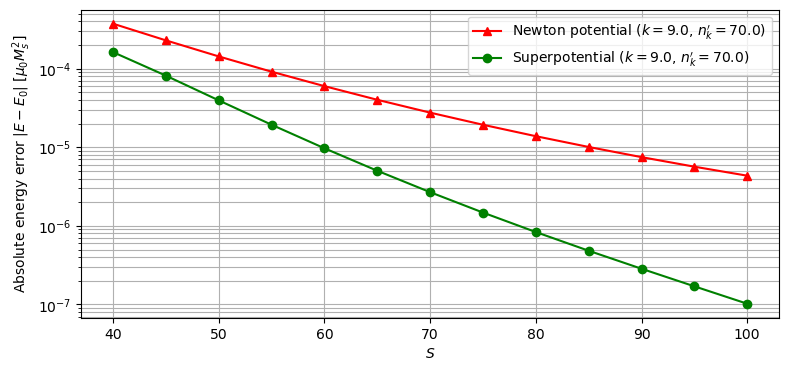

In [31]:
plt.figure(figsize=(9, 4))
hosf_result = pd.read_csv("energy_uniform_s_np.csv")
ss = hosf_result.s.unique()
k = hosf_result.loc[0].k
n = hosf_result.loc[0].n

plt.plot(ss, abs(hosf_result.energy - 1 / 6), "-^", color="red", label=f"Newton potential ($k={k}$, $n_k'={n}$)")
#plt.plot(ss, [9e-3 * 1.09 ** (-s) for s in ss], "--", color="k", label=r"$\sim 1.05^{-s}$")

hosf_result = pd.read_csv("energy_uniform_s_sp.csv")
ss = hosf_result.s.unique()
k = hosf_result.loc[0].k
n = hosf_result.loc[0].n

plt.plot(ss, abs(hosf_result.energy - 1 / 6), "-o", color="green", label=f"Superpotential ($k={k}$, $n_k'={n}$)")
#plt.plot(ss, [5e-2 * 1.14 ** (-s) for s in ss], ":", color="k", label=r"$\sim 1.135^{-s}$")
plt.xlabel("$S$")
plt.ylabel(r"Absolute energy error $|E - E_0|$ $[\mu_0 M_s^2]$")
plt.yscale("log")
plt.legend()
plt.grid(which="both")

## Energy for flower and vortex state

The same energy computation with the same setup is done for a flower and vortex state in the unit cube.

### Flower state:

In [ ]:
# flower state
for k in [3, 4, 5, 6, 7]:
    for n in [10, 20, 40, 80]:
        grid = TensorGrid(*[jnp.linspace(-0.5, 0.5, n)] * 3)
        model = BSpline(grid, degree=k - 1)
        solver = setup(model, target_tg)
        mag = fit_mag(solver, flower_state)  # prefit magnetization to functional Tucker format
        e = solve(solver, mag).block_until_ready()
        t = %timeit -q -o -n 10 -r 1 solve(solver, mag).block_until_ready()
        print(f"k={k}, r={n}, energy={e:.6e}, fitting_time={t.average * 1000:.3f} ms")
        data = {
            "k": k,
            "r": n,
            "s": 100,
            "energy": e,
            "run_time": t.average
        }
        write_csv_row("energy_flower.csv", data)

k=3, r=10, energy=9.986391e-02, fitting_time=2.134 ms
k=3, r=20, energy=1.068359e-01, fitting_time=3.533 ms
k=3, r=40, energy=1.115540e-01, fitting_time=13.056 ms
k=3, r=80, energy=1.131343e-01, fitting_time=94.773 ms
k=4, r=10, energy=1.481191e-01, fitting_time=2.360 ms
k=4, r=20, energy=1.515183e-01, fitting_time=4.294 ms
k=4, r=40, energy=1.525069e-01, fitting_time=12.387 ms
k=4, r=80, energy=1.527522e-01, fitting_time=89.981 ms
k=5, r=10, energy=1.530675e-01, fitting_time=2.837 ms
k=5, r=20, energy=1.530602e-01, fitting_time=4.035 ms
k=5, r=40, energy=1.529058e-01, fitting_time=13.608 ms
k=5, r=80, energy=1.528368e-01, fitting_time=94.256 ms
k=6, r=10, energy=1.530650e-01, fitting_time=3.051 ms
k=6, r=20, energy=1.528631e-01, fitting_time=4.204 ms
k=6, r=40, energy=1.528162e-01, fitting_time=15.408 ms
k=6, r=80, energy=1.528044e-01, fitting_time=92.850 ms
k=7, r=10, energy=1.528492e-01, fitting_time=3.218 ms
k=7, r=20, energy=1.528131e-01, fitting_time=4.833 ms
k=7, r=40, energy=1.

### Vortex state:

In [ ]:
energies_vortex = defaultdict(dict)

# vortex state
for k in [3, 4, 5, 6, 7]:
    for n in [10, 20, 40, 80]:
        grid = TensorGrid(*[jnp.linspace(-0.5, 0.5, n)] * 3)
        model = BSpline(grid, degree=k - 1)
        solver = setup(model, target_tg)
        mag = fit_mag(solver, vortex_state)  # prefit magnetization to functional Tucker format
        e = solve(solver, mag).block_until_ready()
        energies_vortex[k][n] = e
        t = %timeit -q -o -n 10 -r 1 solve(solver, mag).block_until_ready()
        print(f"k={k}, r={n}, energy={e:.6e}, fitting_time={t.average * 1000:.3f} ms")
        data = {
            "k": k,
            "r": n,
            "s": 100,
            "energy": e,
            "run_time": t.average
        }
        write_csv_row("energy_vortex.csv", data)

k=4, r=10, energy=1.839140e-02, fitting_time=13.520 ms
k=4, r=20, energy=2.083909e-02, fitting_time=20.609 ms
k=4, r=30, energy=2.134449e-02, fitting_time=30.545 ms
k=4, r=40, energy=2.153675e-02, fitting_time=69.733 ms
k=4, r=50, energy=2.163001e-02, fitting_time=107.246 ms
k=4, r=60, energy=2.168215e-02, fitting_time=174.848 ms
k=4, r=70, energy=2.171414e-02, fitting_time=412.651 ms
k=4, r=80, energy=2.173513e-02, fitting_time=664.927 ms
k=5, r=10, energy=2.138978e-02, fitting_time=13.622 ms
k=5, r=20, energy=2.189366e-02, fitting_time=20.386 ms
k=5, r=30, energy=2.187466e-02, fitting_time=37.287 ms
k=5, r=40, energy=2.185373e-02, fitting_time=67.782 ms
k=5, r=50, energy=2.183952e-02, fitting_time=108.503 ms
k=5, r=60, energy=2.182993e-02, fitting_time=179.229 ms
k=5, r=70, energy=2.182323e-02, fitting_time=586.573 ms
k=5, r=80, energy=2.181837e-02, fitting_time=836.126 ms
k=6, r=10, energy=2.331356e-02, fitting_time=17.182 ms
k=6, r=20, energy=2.184117e-02, fitting_time=26.448 ms
k=

2025-11-07 15:12:00.335164: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.61GiB (rounded to 6019645952)requested by op 
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-11-07 15:12:00.336892: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] ***___________________________________________________*_____*_______________________________________
E1107 15:12:00.336929   32809 pjrt_stream_executor_client.cc:2916] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 6019645944 bytes. [tf-allocator-allocation-error='']


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 6019645944 bytes.

## Vortex state in a thin film

For other domains, such as a thin film $[-0.5, 0.5]\times [-0.5, 0.5] \times [-0.05, 0.05]$ we need to adjust the spline model and the quadrature tensor grid. As a reference we have $e_d=0.001562$ computed by *mumax3*. We use $200\times200\times50$ quadrature points.

In [ ]:
# thin film

target_tg = TensorGrid(
    jnp.array([-0.5, 0.5]),
    jnp.array([-0.5, 0.5]),
    jnp.array([-0.05, 0.05]),
).to_gauss((200, 200, 50))


for k in [5, 6, 7, 8]:
    for n in [20, 40, 60]:
        grid = TensorGrid(
            jnp.linspace(-0.5, 0.5, n),
            jnp.linspace(-0.5, 0.5, n),
            jnp.linspace(-0.05, 0.05, n // 4)
        )
        model = BSpline(grid, degree=k - 1)
        solver = setup(model, target_tg)
        mag = fit_mag(solver, vortex_state)  # prefit magnetization to functional Tucker format
        e = solve(solver, mag).block_until_ready()
        t = %timeit -q -o -n 10 -r 1 solve(solver, mag).block_until_ready()
        print(f"k={k}, r={n}, energy={e:.6e}, fitting_time={t.average * 1000:.3f} ms")
        data = {
            "k": k,
            "r": n,
            "s": 100,
            "energy": e,
            "run_time": t.average
        }
        write_csv_row("energy_votex_thin_film.csv", data)

k=5, r=20, energy=1.531723e-03, fitting_time=3.593 ms
k=5, r=40, energy=1.567057e-03, fitting_time=8.123 ms
k=5, r=60, energy=1.569949e-03, fitting_time=17.073 ms
k=6, r=20, energy=1.564452e-03, fitting_time=4.112 ms
k=6, r=40, energy=1.569470e-03, fitting_time=7.959 ms
k=6, r=60, energy=1.568540e-03, fitting_time=17.359 ms
k=7, r=20, energy=1.569122e-03, fitting_time=4.779 ms
k=7, r=40, energy=1.567672e-03, fitting_time=8.953 ms
k=7, r=60, energy=1.567492e-03, fitting_time=19.327 ms
k=8, r=20, energy=1.567743e-03, fitting_time=4.715 ms
k=8, r=40, energy=1.567110e-03, fitting_time=8.931 ms
k=8, r=60, energy=1.567297e-03, fitting_time=21.178 ms


## Thin film with two layers

In this example we demonstrate the higher order stray field method for a thin film with two layers. The top layer $\Omega_1=[-0.4, 0.5][-0.5, 0.5][0, 0.05]$ has a uniform magnetization in the $[0.4, 1, 0.6]^T$ direction and the bottom layer $\Omega_2=[-0.5, 0.4][-0.5, 0.5][-0.05, 0]$ has a uniform magnetization in the $[-1, -0.3, 0.0]^T$ direction. Additionally, we use $M_{s,\Omega_1} = 1$ in $\Omega_1$ and $M_{s, \Omega_2}=2$ in $\Omega_2$.

In [ ]:
n = 40
k = 8

unit_vec = lambda x: x / jnp.linalg.norm(x, keepdims=True)
m1 = lambda x: unit_vec(jnp.array([0.4, 1, 0.6]))
m2 = lambda x: unit_vec(jnp.array([-1, -0.3, 0.0])) * 2  # Ms = 2

magnetization = {
    0: m1,
    1: m2,
}


grid1 = TensorGrid(
    jnp.linspace(-0.4, 0.5, n),
    jnp.linspace(-0.5, 0.5, n),
    jnp.linspace(0.0, 0.05, n // 8),
)
grid2 = TensorGrid(
    jnp.linspace(-0.5, 0.4, n),
    jnp.linspace(-0.5, 0.5, n),
    jnp.linspace(-0.05, 0.0, n // 8),
)

targets = {
    0: TensorGrid(
        jnp.linspace(-0.4, 0.5, 2),
        jnp.linspace(-0.5, 0.5, 2),
        jnp.linspace(0.0, 0.05, 2),
    ).to_gauss((200, 200, 25)),
    1: TensorGrid(
        jnp.linspace(-0.5, 0.4, 2),
        jnp.linspace(-0.5, 0.5, 2),
        jnp.linspace(-0.05, 0.0, 2),
    ).to_gauss((200, 200, 25))
}

models = {
    0: BSpline(grid1, degree=k - 1),
    1: BSpline(grid2, degree=k - 1),
}

solver = setup(models, targets, s=100)
mag = fit_mag(solver, magnetization)  # prefit magnetization to functional Tucker format
e = solve(solver, mag).block_until_ready()

In [ ]:
e

Array(0.01086307, dtype=float64)

In [ ]:
e

Array(0.01086255, dtype=float64)